In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
from collections import Counter
from sklearn.model_selection import  GroupKFold
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import polars as pl

In [23]:
import sklearn
import xgboost

In [25]:
xgboost.__version__

'1.6.2'

In [2]:
np.random.seed(42)

In [3]:
class Config:
    TRAIN_PATH = '../inputs/train.csv'
    TEST_PATH = '../inputs/test.csv'
    TRAIN_LABELS = '../inputs/train_labels.csv'
    SAMPLE_SUBMISSION = '../inputs/sample_submission.csv'

In [4]:
def q2l(x):
    if x <= 3:
        return '0-4'
    if x <= 13:
        return '5-12'
    return '13-22'

In [5]:
columns = [
    (pl.col('level') - pl.col('level').shift(1)).over('session_id','level_group').alias('level_shift'),
    pl.col("page").cast(pl.Float32),
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1)) 
         .fill_null(0)
         .clip(0, 1e9)
         .over(["session_id", "level_group"])
         .alias("elapsed_time_diff")
    ),
    (
        (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1)) 
         .abs()
         .over(["session_id", "level_group"])
        .alias("location_x_diff") 
    ),
    (
        (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1)) 
         .abs()
         .over(["session_id", "level_group"])
        .alias("location_y_diff") 
    ),
    pl.col("fqid").fill_null("fqid_None"),
    pl.col("text_fqid").fill_null("text_fqid_None"),
    pl.col('room_fqid').str.split('.').arr[1].alias('main_room')
]

In [6]:
fqid_lists = {
    '0-4': [
        'intro', 'gramps', 'teddy', 'photo', 'notebook', 'retirement_letter', 'tobasement', 'janitor', 'toentry', 'groupconvo', 'report', 
        'boss', 'wells', 'directory','tocollection', 'cs', 'tunic', 'tunic.hub.slip', 'tostacks', 'outtolunch', 'tocloset', 'tomap', 
        'tunic.historicalsociety', 'tunic.kohlcenter', 'plaque', 'plaque.face.date', 'togrampa','tunic.capitol_0', 'chap1_finale', 
        'chap1_finale_c', 'block_tocollection', 'doorblock', 'block_tomap1', 'block_tomap2','block_0'],
    '5-12': [
        'archivist','block', 'block_0', 'block_1','block_badge','block_badge_2','block_magnify','boss','businesscards',
        'businesscards.card_0.next', 'businesscards.card_1.next', 'businesscards.card_bingo.bingo', 'businesscards.card_bingo.next',
        'chap2_finale_c', 'directory', 'door_block_clean','door_block_talk', 'gramps', 'janitor','journals', 'journals.hub.topics', 
        'journals.pic_0.next', 'journals.pic_1.next', 'journals.pic_2.bingo', 'journals.pic_2.next', 'logbook', 'logbook.page.bingo', 
        'magnify', 'outtolunch', 'photo', 'plaque', 'reader', 'reader.paper0.next', 'reader.paper0.prev', 'reader.paper1.next', 
        'reader.paper1.prev', 'reader.paper2.bingo', 'reader.paper2.next', 'reader.paper2.prev', 'tobasement', 'tocloset_dirty', 
        'tocollection', 'toentry', 'tofrontdesk', 'tohallway', 'tomap', 'tomicrofiche', 'tostacks', 'trigger_coffee', 'trigger_scarf', 
        'tunic', 'tunic.capitol_0', 'tunic.capitol_1', 'tunic.drycleaner', 'tunic.historicalsociety', 'tunic.hub.slip', 'tunic.humanecology',
        'tunic.kohlcenter', 'tunic.library', 'wellsbadge', 'what_happened', 'worker'],
    '13-22': [
        'archivist_glasses',  'block_nelson',  'boss',  'businesscards',  'businesscards.card_0.next',  'businesscards.card_1.next',  
        'businesscards.card_bingo.next',  'ch3start',  'chap4_finale_c',  'coffee',  'colorbook',  'confrontation',  'crane_ranger',  
        'directory',  'directory.closeup.archivist',  'expert',  'flag_girl',  'fox',  'glasses',  'gramps',  'groupconvo_flag',  
        'journals',  'journals.hub.topics',  'journals.pic_0.next',  'journals.pic_1.next',  'journals.pic_2.bingo',  'journals.pic_2.next',  
        'journals_flag',  'journals_flag.hub.topics',  'journals_flag.hub.topics_old',  'journals_flag.pic_0.bingo',  'journals_flag.pic_0.next',  
        'journals_flag.pic_0_old.next',  'journals_flag.pic_1.bingo',  'journals_flag.pic_1.next',  'journals_flag.pic_1_old.next',  
        'journals_flag.pic_2.bingo',  'journals_flag.pic_2.next',  'journals_flag.pic_2_old.next',  'key',  'lockeddoor',  'logbook',  
        'need_glasses',  'outtolunch',  'photo',  'plaque',  'reader',  'reader.paper0.next',  'reader.paper0.prev',  'reader.paper1.next',  
        'reader.paper1.prev',  'reader.paper2.next',  'reader.paper2.prev',  'reader_flag',  'reader_flag.paper0.next',  'reader_flag.paper0.prev', 
        'reader_flag.paper1.next',  'reader_flag.paper1.prev',  'reader_flag.paper2.bingo',  'reader_flag.paper2.next',  'reader_flag.paper2.prev', 
        'remove_cup',  'savedteddy',  'seescratches',  'teddy',  'tobasement',  'tocage',  'tocloset_dirty',  'tocollection',  'tocollectionflag', 
        'toentry',  'tofrontdesk',  'tohallway',  'tomap',  'tomicrofiche',  'tostacks',  'tracks',  'tracks.hub.deer',  'tunic',  'tunic.capitol_1', 
        'tunic.capitol_2',  'tunic.drycleaner',  'tunic.flaghouse',  'tunic.historicalsociety',  'tunic.hub.slip',  'tunic.humanecology', 
        'tunic.kohlcenter',  'tunic.library',  'tunic.wildlife',  'unlockdoor',  'wells',  'worker']}
room_lists = {
    '0-4': [
        'tunic.historicalsociety.closet', 'tunic.historicalsociety.basement', 'tunic.historicalsociety.entry', 'tunic.historicalsociety.collection',
        'tunic.historicalsociety.stacks', 'tunic.kohlcenter.halloffame', 'tunic.capitol_0.hall'],
    '5-12': [
        'tunic.capitol_0.hall', 'tunic.capitol_1.hall', 'tunic.drycleaner.frontdesk', 'tunic.historicalsociety.basement',
        'tunic.historicalsociety.closet_dirty', 'tunic.historicalsociety.collection', 'tunic.historicalsociety.entry',
        'tunic.historicalsociety.frontdesk', 'tunic.historicalsociety.stacks', 'tunic.humanecology.frontdesk',
        'tunic.kohlcenter.halloffame', 'tunic.library.frontdesk','tunic.library.microfiche'],
    '13-22': [
        'tunic.capitol_1.hall',  'tunic.capitol_2.hall',  'tunic.drycleaner.frontdesk',  'tunic.flaghouse.entry',  'tunic.historicalsociety.basement',  
        'tunic.historicalsociety.cage',  'tunic.historicalsociety.closet_dirty',  'tunic.historicalsociety.collection',  
        'tunic.historicalsociety.collection_flag',  'tunic.historicalsociety.entry',  'tunic.historicalsociety.frontdesk',  
        'tunic.historicalsociety.stacks',  'tunic.humanecology.frontdesk',  'tunic.kohlcenter.halloffame',  'tunic.library.frontdesk',  
        'tunic.library.microfiche',  'tunic.wildlife.center']}
text_lists = {
    '0-4': [
        'tunic.historicalsociety.closet.intro', 'tunic.historicalsociety.closet.gramps.intro_0_cs_0', 'tunic.historicalsociety.closet.teddy.intro_0_cs_0',
        'tunic.historicalsociety.closet.teddy.intro_0_cs_5', 'tunic.historicalsociety.closet.photo', 'tunic.historicalsociety.closet.notebook',
        'tunic.historicalsociety.closet.retirement_letter.hub', 'tunic.historicalsociety.basement.janitor','tunic.historicalsociety.entry.groupconvo',
        'tunic.historicalsociety.entry.boss.talktogramps', 'tunic.historicalsociety.entry.wells.talktogramps', 'tunic.historicalsociety.collection.cs',
        'tunic.historicalsociety.collection.tunic.slip', 'tunic.historicalsociety.collection.gramps.found', 'tunic.historicalsociety.stacks.outtolunch',
        'tunic.kohlcenter.halloffame.plaque.face.date', 'tunic.kohlcenter.halloffame.togrampa', 'tunic.historicalsociety.entry.block_tocollection',
        'tunic.historicalsociety.collection.tunic', 'tunic.historicalsociety.closet.doorblock', 'tunic.historicalsociety.entry.block_tomap1',
        'tunic.historicalsociety.entry.block_tomap2', 'tunic.capitol_0.hall.chap1_finale_c', 'tunic.historicalsociety.collection.gramps.lost',
        'tunic.kohlcenter.halloffame.block_0', 'tunic.historicalsociety.collection.gramps.look_0','tunic.historicalsociety.entry.gramps.hub'],
    '5-12': [
        'tunic.capitol_0.hall.boss.talktogramps', 'tunic.capitol_1.hall.boss.haveyougotit', 'tunic.capitol_1.hall.chap2_finale_c',
        'tunic.drycleaner.frontdesk.block_0', 'tunic.drycleaner.frontdesk.block_1', 'tunic.drycleaner.frontdesk.logbook.page.bingo','tunic.drycleaner.frontdesk.worker.done',
        'tunic.drycleaner.frontdesk.worker.done2', 'tunic.drycleaner.frontdesk.worker.hub','tunic.drycleaner.frontdesk.worker.takealook',
        'tunic.historicalsociety.basement.janitor','tunic.historicalsociety.closet_dirty.door_block_clean', 'tunic.historicalsociety.closet_dirty.door_block_talk',
        'tunic.historicalsociety.closet_dirty.gramps.archivist', 'tunic.historicalsociety.closet_dirty.gramps.helpclean',
        'tunic.historicalsociety.closet_dirty.gramps.news', 'tunic.historicalsociety.closet_dirty.gramps.nothing', 'tunic.historicalsociety.closet_dirty.photo',
        'tunic.historicalsociety.closet_dirty.trigger_coffee', 'tunic.historicalsociety.closet_dirty.trigger_scarf', 'tunic.historicalsociety.closet_dirty.what_happened',
        'tunic.historicalsociety.frontdesk.archivist.foundtheodora','tunic.historicalsociety.frontdesk.archivist.have_glass',
        'tunic.historicalsociety.frontdesk.archivist.have_glass_recap', 'tunic.historicalsociety.frontdesk.archivist.hello',
        'tunic.historicalsociety.frontdesk.archivist.need_glass_0', 'tunic.historicalsociety.frontdesk.archivist.need_glass_1',
        'tunic.historicalsociety.frontdesk.archivist.newspaper', 'tunic.historicalsociety.frontdesk.archivist.newspaper_recap',
        'tunic.historicalsociety.frontdesk.block_magnify', 'tunic.historicalsociety.frontdesk.magnify',
        'tunic.historicalsociety.stacks.block', 'tunic.historicalsociety.stacks.journals.pic_2.bingo',
        'tunic.historicalsociety.stacks.outtolunch', 'tunic.humanecology.frontdesk.block_0',
        'tunic.humanecology.frontdesk.block_1', 'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo',
        'tunic.humanecology.frontdesk.worker.badger', 'tunic.humanecology.frontdesk.worker.intro',
        'tunic.library.frontdesk.block_badge', 'tunic.library.frontdesk.block_badge_2', 'tunic.library.frontdesk.wellsbadge.hub',
        'tunic.library.frontdesk.worker.droppedbadge', 'tunic.library.frontdesk.worker.hello', 'tunic.library.frontdesk.worker.hello_short',
        'tunic.library.frontdesk.worker.preflag','tunic.library.frontdesk.worker.wells', 'tunic.library.frontdesk.worker.wells_recap',
        'tunic.library.microfiche.block_0', 'tunic.library.microfiche.reader.paper2.bingo'],
    '13-22': [
        'tunic.capitol_1.hall.boss.writeitup',  'tunic.capitol_2.hall.boss.haveyougotit',  'tunic.capitol_2.hall.chap4_finale_c',  
        'tunic.drycleaner.frontdesk.worker.done2',  'tunic.flaghouse.entry.colorbook',  'tunic.flaghouse.entry.flag_girl.hello',  
        'tunic.flaghouse.entry.flag_girl.hello_recap',  'tunic.flaghouse.entry.flag_girl.symbol',  'tunic.flaghouse.entry.flag_girl.symbol_recap',  
        'tunic.historicalsociety.basement.ch3start',  'tunic.historicalsociety.basement.gramps.seeyalater',  'tunic.historicalsociety.basement.gramps.whatdo',  
        'tunic.historicalsociety.basement.savedteddy',  'tunic.historicalsociety.basement.seescratches',  'tunic.historicalsociety.cage.confrontation',  
        'tunic.historicalsociety.cage.glasses.afterteddy',  'tunic.historicalsociety.cage.glasses.beforeteddy',  'tunic.historicalsociety.cage.lockeddoor',  
        'tunic.historicalsociety.cage.need_glasses',  'tunic.historicalsociety.cage.teddy.trapped',  'tunic.historicalsociety.cage.unlockdoor',  
        'tunic.historicalsociety.closet_dirty.photo',  'tunic.historicalsociety.collection_flag.gramps.flag',  
        'tunic.historicalsociety.collection_flag.gramps.recap',  'tunic.historicalsociety.entry.boss.flag',  'tunic.historicalsociety.entry.boss.flag_recap',  
        'tunic.historicalsociety.entry.directory.closeup.archivist',  'tunic.historicalsociety.entry.groupconvo_flag',  
        'tunic.historicalsociety.entry.wells.flag',  'tunic.historicalsociety.entry.wells.flag_recap',  
        'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation',  'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap',  
        'tunic.historicalsociety.frontdesk.key',  'tunic.historicalsociety.stacks.journals.pic_2.bingo',  
        'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo',  'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo',  
        'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo',  'tunic.historicalsociety.stacks.outtolunch',  
        'tunic.humanecology.frontdesk.worker.badger',  'tunic.library.frontdesk.block_nelson',  'tunic.library.frontdesk.worker.flag',  
        'tunic.library.frontdesk.worker.flag_recap',  'tunic.library.frontdesk.worker.nelson',  'tunic.library.frontdesk.worker.nelson_recap',  
        'tunic.library.frontdesk.worker.preflag',  'tunic.library.microfiche.reader_flag.paper2.bingo',  'tunic.wildlife.center.coffee',  
        'tunic.wildlife.center.crane_ranger.crane',  'tunic.wildlife.center.expert.recap',  'tunic.wildlife.center.expert.removed_cup',  
        'tunic.wildlife.center.fox.concern',  'tunic.wildlife.center.remove_cup',  'tunic.wildlife.center.tracks.hub.deer',  
        'tunic.wildlife.center.wells.animals',  'tunic.wildlife.center.wells.animals2',  'tunic.wildlife.center.wells.nodeer',  
        'tunic.wildlife.center.wells.nodeer_recap']}
CATS = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid']
NUMS = ['page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
        'hover_duration', 'elapsed_time_diff']
LEVELS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

event_features =  ['checkpoint_click','cutscene_click', 'person_click', 'navigate_click',
                   'observation_click', 'notification_click', 'object_click',
                   'object_hover', 'map_hover', 'map_click', 'notebook_click']
name_features = ['basic', 'undefined', 'close', 'open', 'prev', 'next']
room_features = {k:[i.split('.')[1] for i in v] for k,v in room_lists.items()}
text_features_level_1 = {k:set([i.split('.')[1] for i in v]) for k,v in text_lists.items()}
text_features_level_2 = {k:set([i.split('.')[2] for i in v]) for k,v in text_lists.items()}
room_events = {k:set([f"{x}_{y}" for x in event_features for y in v]) for k,v in room_features.items()}

In [7]:
def time_feature(train):
    train["year"] = train["session_id"].apply(lambda x: int(str(x)[:2])).astype(np.uint8)
    train["month"] = train["session_id"].apply(lambda x: int(str(x)[2:4])+1).astype(np.uint8)
    train["day"] = train["session_id"].apply(lambda x: int(str(x)[4:6])).astype(np.uint8)
    train["hour"] = train["session_id"].apply(lambda x: int(str(x)[6:8])).astype(np.uint8)
    train["minute"] = train["session_id"].apply(lambda x: int(str(x)[8:10])).astype(np.uint8)
    train["second"] = train["session_id"].apply(lambda x: int(str(x)[10:12])).astype(np.uint8)


    return train

In [8]:
def feature_engineer(x, grp):
    fqid_list_grp = fqid_lists[grp]
    room_list_grp = room_lists[grp]
    text_list_grp = text_lists[grp]
    room_event_grp = room_events[grp]
    
    aggs = [
#     pl.col('level_shift').min().alias('level_shift_min'),
#     pl.col('level_shift').apply(lambda x: x < 0).sum().alias('n_level_shift_negative'),
#     pl.col("elapsed_time_diff").filter(pl.col("level_shift") < 0)\
#         .mean().alias(f"elapsed_time_diff_level_shift_negative_mean"),
#     pl.col("elapsed_time_diff").filter(pl.col("level_shift") < 0)\
#         .std().alias(f"elapsed_time_diff_level_shift_negative_std"), 
#     pl.col("elapsed_time_diff").filter(pl.col("level_shift") < 0)\
#         .min().alias(f"elapsed_time_diff_level_shift_negative_min"),
#     pl.col("elapsed_time_diff").filter(pl.col("level_shift") < 0)\
#         .min().alias(f"elapsed_time_diff_level_shift_negative_max"),
#     pl.col("elapsed_time_diff").filter(pl.col("level_shift") >= 0)\
#         .mean().alias(f"elapsed_time_diff_level_shift_positive_mean"),
#     pl.col("elapsed_time_diff").filter(pl.col("level_shift") >= 0)\
#         .std().alias(f"elapsed_time_diff_level_shift_positive_std"), 
#     pl.col("elapsed_time_diff").filter(pl.col("level_shift") >= 0)\
#         .min().alias(f"elapsed_time_diff_level_shift_positive_min"), 
#     pl.col("elapsed_time_diff").filter(pl.col("level_shift") >= 0)\
#         .min().alias(f"elapsed_time_diff_level_shift_positive_max"), 
    (pl.col('elapsed_time').apply(lambda x: x.max() - x.min())).alias('duration'),
    # *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique") for c in CATS],
    (pl.col('text_fqid').is_null().count().alias('text_fqid_null')),
    (pl.col('hover_duration').mean()
     .alias(f"hover_duration_mean")),
    (pl.col('hover_duration').std()
     .alias(f"hover_duration_std")),
    (pl.col('hover_duration').max()
     .alias(f"hover_duration_max")),
    (pl.col('hover_duration').min()
     .alias(f"hover_duration_min")),
#     *[pl.col("hover_duration").filter(pl.col("level") == i).sum()
#       .alias(f'hover_duration_level_{i}') for i in range(0,23)],
    (pl.col('elapsed_time_diff').quantile(0.1, "nearest")
     .alias(f"elapsed_time_diff_q1")),
    (pl.col('elapsed_time_diff').quantile(0.2, "nearest")
     .alias(f"elapsed_time_diff_q2")),
    (pl.col('elapsed_time_diff').quantile(0.3, "nearest")
     .alias(f"elapsed_time_diff_q3")),
    (pl.col('elapsed_time_diff').quantile(0.4, "nearest")
     .alias(f"elapsed_time_diff_q4")),
    (pl.col('elapsed_time_diff').quantile(0.6, "nearest")
     .alias(f"elapsed_time_diff_q6")),
    (pl.col('elapsed_time_diff').quantile(0.7, "nearest")
     .alias(f"elapsed_time_diff_q7")),
    (pl.col('elapsed_time_diff').quantile(0.8, "nearest")
     .alias(f"elapsed_time_diff_q8")),
    (pl.col('elapsed_time_diff').quantile(0.9, "nearest")
     .alias(f"elapsed_time_diff_q9")),
    (pl.col('elapsed_time_diff').mean()
     .alias(f"elapsed_time_diff_mean")),
    (pl.col('elapsed_time_diff').std()
     .alias(f"elapsed_time_diff_std")),
    (pl.col('elapsed_time_diff').max()
     .alias(f"elapsed_time_diff_max")),
    (pl.col('elapsed_time_diff').min()
     .alias(f"elapsed_time_diff_min")),
    *[pl.col("room_event").filter(pl.col("room_event") == c)
        .count().alias(f"{c}_room_event_counts") 
      for c in room_event_grp],
    *[pl.col("event_name").filter(pl.col("event_name") == c)
        .count().alias(f"{c}_event_counts") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .quantile(0.1, "nearest").alias(f"elapsed_time_diff_{c}_q1") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .quantile(0.2, "nearest").alias(f"elapsed_time_diff_{c}_q2") 
      for c in event_features ],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .quantile(0.3, "nearest").alias(f"elapsed_time_diff_{c}_q3") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .quantile(0.4, "nearest").alias(f"elapsed_time_diff_{c}_q4") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .quantile(0.6, "nearest").alias(f"elapsed_time_diff_{c}_q6") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .quantile(0.7, "nearest").alias(f"elapsed_time_diff_{c}_q7") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .quantile(0.8, "nearest").alias(f"elapsed_time_diff_{c}_q8") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .quantile(0.9, "nearest").alias(f"elapsed_time_diff_{c}_q9") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .mean().alias(f"elapsed_time_diff_{c}_mean") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .std().alias(f"elapsed_time_diff_{c}_std") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .min().alias(f"elapsed_time_diff_{c}_min") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .max().alias(f"elapsed_time_diff_{c}_max") 
      for c in event_features],
    
    *[pl.col("fqid").filter(pl.col("fqid") == c)
        .count().alias(f"{c}_fqid_counts") 
      for c in fqid_list_grp],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .quantile(0.1, "nearest").alias(f"elapsed_time_diff_{c}_q1") 
      for c in fqid_list_grp],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .quantile(0.2, "nearest").alias(f"elapsed_time_diff_{c}_q2") 
      for c in fqid_list_grp ],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .quantile(0.3, "nearest").alias(f"elapsed_time_diff_{c}_q3") 
      for c in fqid_list_grp],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .quantile(0.4, "nearest").alias(f"elapsed_time_diff_{c}_q4") 
      for c in fqid_list_grp],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .quantile(0.6, "nearest").alias(f"elapsed_time_diff_{c}_q6") 
      for c in fqid_list_grp],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .quantile(0.7, "nearest").alias(f"elapsed_time_diff_{c}_q7") 
      for c in fqid_list_grp],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .quantile(0.8, "nearest").alias(f"elapsed_time_diff_{c}_q8") 
      for c in fqid_list_grp],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .quantile(0.9, "nearest").alias(f"elapsed_time_diff_{c}_q9") 
      for c in fqid_list_grp],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .mean().alias(f"elapsed_time_diff_{c}_mean") 
      for c in fqid_list_grp],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .std().alias(f"elapsed_time_diff_{c}_std") 
      for c in fqid_list_grp],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .min().alias(f"elapsed_time_diff_{c}_min") 
      for c in fqid_list_grp],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .max().alias(f"elapsed_time_diff_{c}_max") 
      for c in fqid_list_grp],
    
    *[pl.col("text_fqid").filter(pl.col("text_fqid") == c)
        .count().alias(f"{c}_text_fqid_counts")
      for c in text_list_grp],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .quantile(0.1, "nearest").alias(f"elapsed_time_diff_{c}_q1") 
      for c in text_list_grp],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .quantile(0.2, "nearest").alias(f"elapsed_time_diff_{c}_q2") 
      for c in text_list_grp ],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .quantile(0.3, "nearest").alias(f"elapsed_time_diff_{c}_q3") 
      for c in text_list_grp],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .quantile(0.4, "nearest").alias(f"elapsed_time_diff_{c}_q4") 
      for c in text_list_grp],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .quantile(0.6, "nearest").alias(f"elapsed_time_diff_{c}_q6") 
      for c in text_list_grp],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .quantile(0.7, "nearest").alias(f"elapsed_time_diff_{c}_q7") 
      for c in text_list_grp],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .quantile(0.8, "nearest").alias(f"elapsed_time_diff_{c}_q8") 
      for c in text_list_grp],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .quantile(0.9, "nearest").alias(f"elapsed_time_diff_{c}_q9") 
      for c in text_list_grp],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .mean().alias(f"elapsed_time_diff_{c}_mean") 
      for c in text_list_grp],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .std().alias(f"elapsed_time_diff_{c}_std") 
      for c in text_list_grp],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .min().alias(f"elapsed_time_diff_{c}_min") 
      for c in text_list_grp],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .max().alias(f"elapsed_time_diff_{c}_max") 
      for c in text_list_grp],

    *[pl.col("location_x_diff").filter(pl.col("event_name")==c).mean().alias(f"{c}_ET_mean_x") for c in event_features],
    *[pl.col("location_x_diff").filter(pl.col("event_name")==c).std().alias(f"{c}_ET_std_x") for c in event_features],
    *[pl.col("location_x_diff").filter(pl.col("event_name")==c).max().alias(f"{c}_ET_max_x") for c in event_features],
    *[pl.col("location_x_diff").filter(pl.col("event_name")==c).min().alias(f"{c}_ET_min_x") for c in event_features]        
]
    
    if grp=='0-4':
        aggs.extend([pl.col("elapsed_time").filter(pl.col("level") == i)
          .apply(lambda x: x.max() - x.min() if len(x) > 0 else 0)
          .alias(f'duration_level_{i}') for i in range(0,5)])
    if grp=='5-12':
        aggs.extend([pl.col("elapsed_time").filter(pl.col("level") == i)
          .apply(lambda x: x.max() - x.min() if len(x) > 0 else 0)
          .alias(f'duration_level_{i}') for i in range(5,13)])
    if grp=='13-22':
        aggs.extend([pl.col("elapsed_time").filter(pl.col("level") == i)
          .apply(lambda x: x.max() - x.min() if len(x) > 0 else 0)
          .alias(f'duration_level_{i}') for i in range(13,23)])
    df = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
    for col1 in event_features[1:]:
        for col2 in event_features[1:]:
            if col1!=col2:
                
                df = df.with_columns([pl.struct([f'{col1}_event_counts',f'{col2}_event_counts'])\
                                          .apply(lambda x: x[f'{col1}_event_counts']/(x[f'{col1}_event_counts']+x[f'{col2}_event_counts']+1))\
                                          .alias(f'{col1}/({col1}+{col2})')])
    return df.to_pandas()

In [9]:
df = (pl.read_csv(Config.TRAIN_PATH)
      .drop(["fullscreen", "hq", "music"])
      .with_columns(columns))
df=df.with_columns((pl.col('event_name') + '_' + pl.col('main_room')).alias('room_event'))

In [10]:
df1 = df.filter(pl.col("level_group")=='0-4')
df2 = df.filter(pl.col("level_group")=='5-12')
# df2 = df.filter((pl.col("level_group")=='5-12')|(pl.col("level_group")=='0-4'))
df3 = df.filter(pl.col("level_group")=='13-22')
# df3 = df.clone()
df1.shape,df2.shape,df3.shape

((1994687, 23), (4433127, 23), (6746397, 23))

In [11]:
%%time
df1 = feature_engineer(df1, grp='0-4')
print('df1 done',df1.shape)
df2 = feature_engineer(df2, grp='5-12')
print('df2 done',df2.shape)
df3 = feature_engineer(df3, grp='13-22')
print('df3 done',df3.shape)

df1 done (11779, 1140)
df2 done (11779, 1837)
df3 done (11779, 2342)
CPU times: total: 2min 11s
Wall time: 18 s


In [12]:
df1 = time_feature(df1)
df2 = time_feature(df2)
df3 = time_feature(df3)

In [13]:
null1 = df1.isnull().sum().sort_values(ascending=False) / len(df1)
null2 = df2.isnull().sum().sort_values(ascending=False) / len(df1)
null3 = df3.isnull().sum().sort_values(ascending=False) / len(df1)

drop1 = list(null1[null1>0.9].index)
drop2 = list(null2[null2>0.9].index)
drop3 = list(null3[null3>0.9].index)
print(len(drop1), len(drop2), len(drop3))

for col in df1.columns:
    if df1[col].nunique()==1:
        print(col)
        drop1.append(col)
print("*********df1 DONE*********")
for col in df2.columns:
    if df2[col].nunique()==1:
        print(col)
        drop2.append(col)
print("*********df2 DONE*********")
for col in df3.columns:
    if df3[col].nunique()==1:
        print(col)
        drop3.append(col)
print("*********df3 DONE*********")

155 216 456
elapsed_time_diff_min
object_click_capitol_0_room_event_counts
checkpoint_click_capitol_0_room_event_counts
checkpoint_click_historicalsociety_room_event_counts
notebook_click_capitol_0_room_event_counts
observation_click_capitol_0_room_event_counts
person_click_kohlcenter_room_event_counts
person_click_capitol_0_room_event_counts
object_hover_capitol_0_room_event_counts
checkpoint_click_kohlcenter_room_event_counts
notification_click_capitol_0_room_event_counts
checkpoint_click_event_counts
elapsed_time_diff_intro_min
elapsed_time_diff_tunic.historicalsociety.closet.intro_min
object_hover_ET_std_x
map_hover_ET_std_x
*********df1 DONE*********
elapsed_time_diff_min
notification_click_capitol_1_room_event_counts
cutscene_click_drycleaner_room_event_counts
person_click_kohlcenter_room_event_counts
object_hover_capitol_0_room_event_counts
checkpoint_click_capitol_1_room_event_counts
checkpoint_click_historicalsociety_room_event_counts
observation_click_kohlcenter_room_event_co

In [14]:
df1 = df1.set_index('session_id')
df2 = df2.set_index('session_id')
df3 = df3.set_index('session_id')

FEATURES1 = [c for c in df1.columns if c not in drop1+['level_group']]
FEATURES2 = [c for c in df2.columns if c not in drop2+['level_group']]
FEATURES3 = [c for c in df3.columns if c not in drop3+['level_group']]
print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3) ,'features')
ALL_USERS = df1.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 975 1599 1854 features
We will train with 11779 users info


In [26]:
df3.join(df1,suff)

ValueError: columns overlap but no suffix specified: Index(['duration', 'text_fqid_null', 'hover_duration_mean',
       'hover_duration_std', 'hover_duration_max', 'hover_duration_min',
       'elapsed_time_diff_q1', 'elapsed_time_diff_q2', 'elapsed_time_diff_q3',
       'elapsed_time_diff_q4',
       ...
       'notebook_click/(notebook_click+object_click)',
       'notebook_click/(notebook_click+object_hover)',
       'notebook_click/(notebook_click+map_hover)',
       'notebook_click/(notebook_click+map_click)', 'year', 'month', 'day',
       'hour', 'minute', 'second'],
      dtype='object', length=557)

In [15]:
targets = pd.read_csv(Config.TRAIN_LABELS)
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
print(targets.shape)

(212022, 4)


In [16]:
from collections import defaultdict

In [17]:
target_pivot = targets.pivot(index='session', columns='q',values ='correct').reset_index()
target_pivot.rename(columns={'session':'session_id'},inplace=True)
target_pivot.set_index('session_id',inplace=True)

In [18]:
from lightgbm import LGBMClassifier
xgb_params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'tree_method': 'gpu_hist',
        'eval_metric':'logloss',
        'learning_rate': 0.02,
        'alpha': 8,
        'max_depth': 4,
        'n_estimators': 9999,
        'early_stopping_rounds': 90,
        'subsample':0.8,
        'colsample_bytree': 0.5,
        'seed': 42
    }
lgb_params = {
    'learning_rate': 0.015,
    'max_depth': 4,
    'n_estimators': 9999,
    'subsample':0.8,
    'colsample_bytree': 0.5,
    'reg_alpha': 8,
    'device':'gpu',
    'seed': 42
}

In [19]:
%%time
gkf = GroupKFold(n_splits=5)
oof_xgb = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS, columns=[f'meta_{i}' for i in range(1, 19)])
#models = {}
best_iteration_xgb = defaultdict(list)
importance_dict = {}
use_merge=False
model_type='xgboost'
# ITERATE THRU QUESTIONS 1 THRU 18
for t in range(1,19):

    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif t<=13: 
        grp = '5-12'
        if use_merge:
            df = df2.join(target_pivot[[i for i in range(1,4)]])
            FEATURES = FEATURES2 + [i for i in range(1,4)]
        else:
            df = df2
            FEATURES = FEATURES2
    elif t<=22: 
        grp = '13-22'
        if use_merge:
            df = df3.join(target_pivot[[i for i in range(1,14)]])
            FEATURES = FEATURES3 + [i for i in range(1,14)]
        else:
            df = df3
            FEATURES = FEATURES3
        
    print('#'*25)
    print('### question', t, 'with features', len(FEATURES))
    print('#'*25)
    df.fillna(0, inplace=True)
    
    feature_importance_df = pd.DataFrame()
    # COMPUTE CV SCORE WITH 5 GROUP K FOLD
    for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
        
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        if model_type=='xgboost':
        # TRAIN MODEL        
            clf =  XGBClassifier(**xgb_params)
            clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                    eval_set=[(valid_x[FEATURES].astype('float32'), valid_y['correct'])],
                    verbose=100)
            print(i+1, ', ', end='')
            best_iteration_xgb[str(t)].append(clf.best_ntree_limit)

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = FEATURES
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = i + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            # SAVE MODEL, PREDICT VALID OOF
            oof_xgb.loc[valid_users, f'meta_{t}'] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
            
        if model_type=='lightgbm':
            clf = LGBMClassifier(**lgb_params)
            clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                    eval_set=[(valid_x[FEATURES].astype('float32'), valid_y['correct'])],
                    early_stopping_rounds=90,
                    verbose=100)
            print(i+1, ', ', end='')
            best_iteration_xgb[str(t)].append(clf.best_iteration_)

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = FEATURES
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = i + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
            oof_xgb.loc[valid_users, f'meta_{t}'] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
       
    print()
#     feature_importance_df = feature_importance_df.groupby(['feature'])['importance'].agg(['mean']).sort_values(by='mean', ascending=False)
#     display(feature_importance_df.head(10))

#########################
### question 1 with features 975
#########################
[0]	validation_0-logloss:0.68737
[100]	validation_0-logloss:0.51409
[200]	validation_0-logloss:0.49485
[300]	validation_0-logloss:0.49000
[400]	validation_0-logloss:0.48906
[500]	validation_0-logloss:0.48866
[600]	validation_0-logloss:0.48841
[700]	validation_0-logloss:0.48829
[735]	validation_0-logloss:0.48825
1 , [0]	validation_0-logloss:0.68717
[100]	validation_0-logloss:0.50847
[200]	validation_0-logloss:0.48958
[300]	validation_0-logloss:0.48681
[400]	validation_0-logloss:0.48562
[500]	validation_0-logloss:0.48546
[536]	validation_0-logloss:0.48545
2 , [0]	validation_0-logloss:0.68779
[100]	validation_0-logloss:0.53806
[200]	validation_0-logloss:0.52453
[300]	validation_0-logloss:0.52226
[400]	validation_0-logloss:0.52168
[500]	validation_0-logloss:0.52108
[600]	validation_0-logloss:0.52092
[649]	validation_0-logloss:0.52109
3 , [0]	validation_0-logloss:0.68740
[100]	validation_0-logloss:0.52371
[

0.400, 0.405, 0.410, 0.415, 0.420, 0.425, 0.430, 0.435, 0.440, 0.445, 0.450, 0.455, 0.460, 0.465, 0.470, 0.475, 0.480, 0.485, 0.490, 0.495, 0.500, 0.505, 0.510, 0.515, 0.520, 0.525, 0.530, 0.535, 0.540, 0.545, 0.550, 0.555, 0.560, 0.565, 0.570, 0.575, 0.580, 0.585, 0.590, 0.595, 0.600, 0.605, 0.610, 0.615, 0.620, 0.625, 0.630, 0.635, 0.640, 0.645, 0.650, 0.655, 0.660, 0.665, 0.670, 0.675, 0.680, 0.685, 0.690, 0.695, 0.700, 0.705, 0.710, 0.715, 0.720, 0.725, 0.730, 0.735, 0.740, 0.745, 0.750, 0.755, 0.760, 0.765, 0.770, 0.775, 0.780, 0.785, 0.790, 0.795, 0.800, 0.805, 

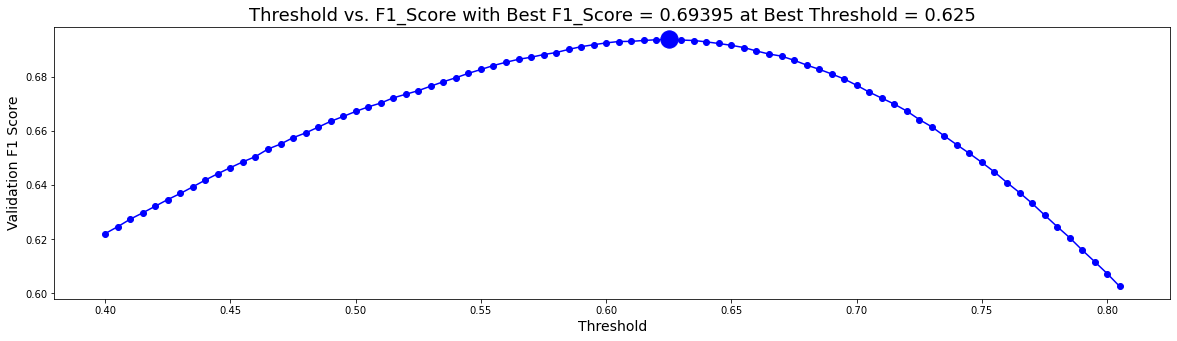

In [20]:
true = oof_xgb.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.005):
    print(f'{threshold:.03f}, ',end='')
    preds = (oof_xgb.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()

In [21]:
pd.DataFrame({'feature':FEATURES1}).to_csv('feature.csv')

In [22]:
import sklearn, xgboost
print(sklearn.__version__)
print(xgboost.__version__)

1.0.2
1.6.2
